Loading training and validation data...


Loading label 4: 100%|██████████| 27/27 [00:00<00:00, 108.62it/s]


Total training samples after combining: 2170
Loading test data...


Loading label 4: 100%|██████████| 51/51 [00:00<00:00, 127.94it/s]


Total test samples: 621
Extracting features from training data...


Extracting training features: 100%|██████████| 2170/2170 [00:23<00:00, 93.51it/s]


Extracting features from test data...


Extracting test features: 100%|██████████| 621/621 [00:06<00:00, 93.97it/s]


Scaling features...
Training Random Forest...
Random Forest training completed.
Evaluating on test data...
Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.83      0.80       296
           3       0.60      0.65      0.63       223
           4       1.00      0.53      0.69       102

    accuracy                           0.72       621
   macro avg       0.79      0.67      0.71       621
weighted avg       0.74      0.72      0.72       621



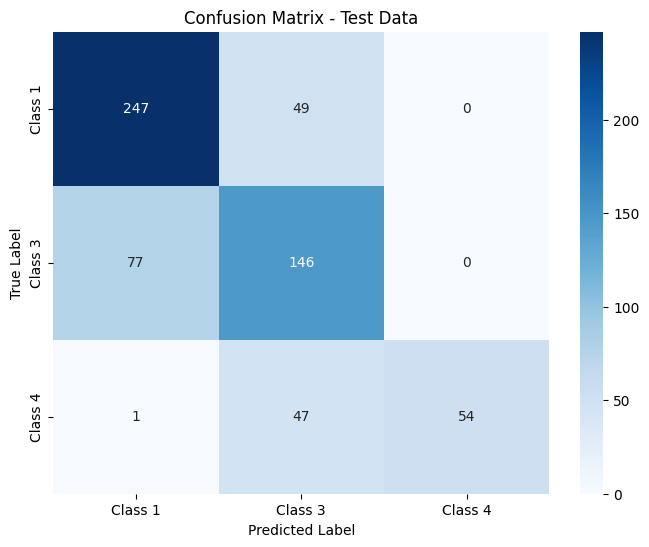

Model and scaler saved and zipped successfully.


/kaggle/working/rf_model_and_scaler.zip

In [1]:
import numpy as np
import cv2
import os
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from IPython.display import FileLink
import zipfile

warnings.filterwarnings('ignore')

# 1. Image Preprocessing Function

def preprocess_image(image):
    """
    Apply image preprocessing steps:
    - Denoising using Gaussian Blur
    - Contrast Enhancement using Histogram Equalization
    """
    # Denoising
    denoised = cv2.GaussianBlur(image, (5, 5), 0)

    # Contrast Enhancement
    enhanced = cv2.equalizeHist(denoised)

    return enhanced


# 2. Augmentation Function

def augment_image(image, augmentation_methods=['rotate', 'flip', 'noise'], num_augmented=1):
    """
    Perform augmentation on a given image.
    Augmentation methods include:
    - Rotation
    - Horizontal Flip
    - Adding Random Noise
    """
    augmented_images = []

    for _ in range(num_augmented):
        augmented = image.copy()

        # Rotate the image by a random angle
        if 'rotate' in augmentation_methods:
            angle = np.random.randint(-15, 15)
            center = (augmented.shape[1] // 2, augmented.shape[0] // 2)
            rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented = cv2.warpAffine(augmented, rot_mat, (augmented.shape[1], augmented.shape[0]))

        # Flip the image horizontally
        if 'flip' in augmentation_methods:
            augmented = cv2.flip(augmented, 1)

        # Add random noise
        if 'noise' in augmentation_methods:
            noise = np.random.normal(0, 5, augmented.shape)
            augmented = np.clip(augmented + noise, 0, 255).astype(np.uint8)

        augmented_images.append(augmented)

    return augmented_images


# 3. Data Loading Function with Augmentation for Class 4

def load_data_from_folder(data_dir, image_size=(128, 128), classes_to_keep=None, max_samples_per_class=800, augment_class_4_to=300):
    """
    Load images, apply preprocessing, and filter by specific classes.
    Additionally, augment class 4 to a specified number of samples.
    """
    data = []
    labels = []
    for label in sorted(os.listdir(data_dir)):
        label_path = os.path.join(data_dir, label)
        if not os.path.isdir(label_path):
            continue
        # Keep only specific classes
        if classes_to_keep is not None and int(label) not in classes_to_keep:
            continue
        
        # Limit the number of samples per class
        image_count = 0
        class_data = []  # Temporary storage for augmentation
        for img_name in tqdm(os.listdir(label_path), desc=f'Loading label {label}'):
            if image_count >= max_samples_per_class and int(label) != 4:
                break
            img_path = os.path.join(label_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            image = cv2.resize(image, image_size)  # Resize the image
            image = preprocess_image(image)  # Apply preprocessing
            class_data.append(image)
            image_count += 1

        # Handle augmentation for class 4
        if int(label) == 4 and len(class_data) < augment_class_4_to:
            num_to_augment = augment_class_4_to - len(class_data)
            for image in class_data[:num_to_augment]:  # Augment existing images
                augmented_images = augment_image(image, num_augmented=1)
                class_data.extend(augmented_images)

        # Append the images to final dataset
        data.extend(class_data)
        labels.extend([int(label)] * len(class_data))

    return np.array(data), np.array(labels)


# 4. Feature Extraction Function

def extract_features(image):
    """
    Extract combined HOG and LBP features from an image.
    """
    # HOG Features
    hog_feat = hog(image,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   visualize=False,
                   transform_sqrt=True)

    # LBP Features
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 10),
                             range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    combined_features = np.hstack([hog_feat, hist])

    return combined_features


# 5. Dataset Paths

base_path = '/kaggle/input'  # Adjust this path based on your environment
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')


# 6. Load and Combine Training and Validation Data

print("Loading training and validation data...")
classes_to_keep = [1, 3, 4]  # Keep only classes 1, 3, and 4
X_train_images, y_train = load_data_from_folder(train_path, classes_to_keep=classes_to_keep, max_samples_per_class=800, augment_class_4_to=300)
X_val_images, y_val = load_data_from_folder(val_path, classes_to_keep=classes_to_keep, max_samples_per_class=800, augment_class_4_to=300)

# Combine training and validation data
X_train_combined = np.concatenate((X_train_images, X_val_images), axis=0)
y_train_combined = np.concatenate((y_train, y_val), axis=0)

print(f"Total training samples after combining: {X_train_combined.shape[0]}")

# 7. Load Test Data

print("Loading test data...")
X_test_images, y_test = load_data_from_folder(test_path, classes_to_keep=classes_to_keep, max_samples_per_class=800)
print(f"Total test samples: {X_test_images.shape[0]}")

# 8. Feature Extraction

print("Extracting features from training data...")
hog_features_train = [extract_features(image) for image in tqdm(X_train_combined, desc='Extracting training features')]
hog_features_train = np.array(hog_features_train)

print("Extracting features from test data...")
hog_features_test = [extract_features(image) for image in tqdm(X_test_images, desc='Extracting test features')]
hog_features_test = np.array(hog_features_test)

# 9. Feature Scaling

print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(hog_features_train)
X_test_scaled = scaler.transform(hog_features_test)

# 10. Train Random Forest Classifier

print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train_combined)
print("Random Forest training completed.")

# 11. Evaluation on Test Data

print("Evaluating on test data...")
y_test_pred = rf_model.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# 12. Confusion Matrix

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {c}" for c in classes_to_keep],
            yticklabels=[f"Class {c}" for c in classes_to_keep])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 13. Save the Trained Model and Scaler

joblib.dump(rf_model, 'trained_rf_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

with zipfile.ZipFile('rf_model_and_scaler.zip', 'w') as zipf:
    zipf.write('trained_rf_model.joblib')
    zipf.write('scaler.joblib')

print("Model and scaler saved and zipped successfully.")
display(FileLink('rf_model_and_scaler.zip'))


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print("Detailed Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

# If it's a multi-class problem and you have probability estimates
y_test_proba = svm_model.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovo')
print(f"ROC AUC Score: {roc_auc:.4f}")


Detailed Evaluation Metrics:


NameError: name 'accuracy_score' is not defined